# Model Comparison: Sentiment Indices

**Objective**: Compare the Net Sentiment Indices generated by three different models to assess consistency and divergence.

**Models Compared**:
1. **ZiweiChen/FinBERT-FOMC** (Specialized for Fed Minutes)
2. **Twitter-RoBERTa-Base** (General Social Media Sentiment)
3. **RoBERTa-Large** (General English Sentiment)

**Method**: 
- Align all indices by Month.
- Plot separate time series comparison for each model against Economic Indicators.
- Compute correlation matrix.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Output Paths defined in Part 6 pipelines
# Note: Paths are relative to notebook location
PATH_FINBERT_FOMC = "../data/result/FinBERT-FOMC/monthly_index_FinBERT_FOMC.csv"
PATH_ROBERTA_BASE = "../data/result/RoBERTa_Base/monthly_index_Twitter_RoBERTa.csv"
PATH_ROBERTA_LARGE = "../data/result/RoBERTa_Large/monthly_index_RoBERTa_large.csv"

# Fallback absolute paths (for safety)
BASE_DIR = r"e:\Textming\data\result"
if not os.path.exists(PATH_FINBERT_FOMC):
    PATH_FINBERT_FOMC = os.path.join(BASE_DIR, "FinBERT-FOMC", "monthly_index_FinBERT_FOMC.csv")
if not os.path.exists(PATH_ROBERTA_BASE):
    PATH_ROBERTA_BASE = os.path.join(BASE_DIR, "RoBERTa_Base", "monthly_index_Twitter_RoBERTa.csv")
if not os.path.exists(PATH_ROBERTA_LARGE):
    PATH_ROBERTA_LARGE = os.path.join(BASE_DIR, "RoBERTa_Large", "monthly_index_RoBERTa_large.csv")

In [22]:
def load_index(path, model_name):
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Ensure date format
        col_date = 'month' if 'month' in df.columns else 'date'
        df[col_date] = pd.to_datetime(df[col_date])
        
        # Rename score column to model name
        col_score = 'sentiment_score' if 'sentiment_score' in df.columns else 'sentiment_index'
        df = df[[col_date, col_score]].rename(columns={col_score: model_name, col_date: 'date'})
        
        # Set index for easy joining
        df.set_index('date', inplace=True)
        return df
    else:
        print(f"Warning: File not found for {model_name} at {path}")
        return pd.DataFrame()

# Load Data
df_finbert = load_index(PATH_FINBERT_FOMC, "FinBERT_FOMC")
df_roberta_b = load_index(PATH_ROBERTA_BASE, "RoBERTa_Base")
df_roberta_l = load_index(PATH_ROBERTA_LARGE, "RoBERTa_Large")

# Merge
dfs = [df_finbert, df_roberta_b, df_roberta_l]
dfs = [d for d in dfs if not d.empty]

if dfs:
    df_merged = pd.concat(dfs, axis=1).sort_index()
    df_merged.dropna(how='all', inplace=True)
    print("Merged Data Head:")
    print(df_merged.head())
else:
    print("No data loaded!")

Merged Data Head:
            FinBERT_FOMC  RoBERTa_Base  RoBERTa_Large
date                                                 
2018-01-01      0.380088      0.580995       0.000000
2018-02-01      0.792113      0.707022       0.998664
2018-03-01     -0.251021     -0.146999      -0.306430
2018-04-01     -0.240114      0.004503      -0.818870
2018-05-01      0.077594      0.339394       0.000000


In [23]:
# Load Economic Indicators
PATH_ECON = "../data/raw/econ_indicators.csv"
if not os.path.exists(PATH_ECON):
    PATH_ECON = r"e:\Textming\data\raw\econ_indicators.csv"

if os.path.exists(PATH_ECON):
    df_econ = pd.read_csv(PATH_ECON)
    df_econ['DATE'] = pd.to_datetime(df_econ['DATE'])
    df_econ.rename(columns={'DATE': 'date'}, inplace=True)
    df_econ.set_index('date', inplace=True)
    
    # Filter to matching timeframe
    if 'df_merged' in locals() and not df_merged.empty:
        min_date = df_merged.index.min()
        max_date = df_merged.index.max()
        df_econ = df_econ[(df_econ.index >= min_date) & (df_econ.index <= max_date)]
    
    print("Loaded Economic Indicators:")
    # Ensure we align frequency if needed, but plotting on dates handles it usually
    print(df_econ[['CPI_YoY', 'PPI_YoY', 'Fed_Funds_Rate']].head())
else:
    print("Economic data not found.")
    df_econ = pd.DataFrame()

Loaded Economic Indicators:
             CPI_YoY   PPI_YoY  Fed_Funds_Rate
date                                          
2018-01-01  2.151319  3.775564            1.41
2018-02-01  2.263469  4.018789            1.42
2018-03-01  2.330950  4.073107            1.51
2018-04-01  2.470996  3.782383            1.69
2018-05-01  2.781922  5.394191            1.70


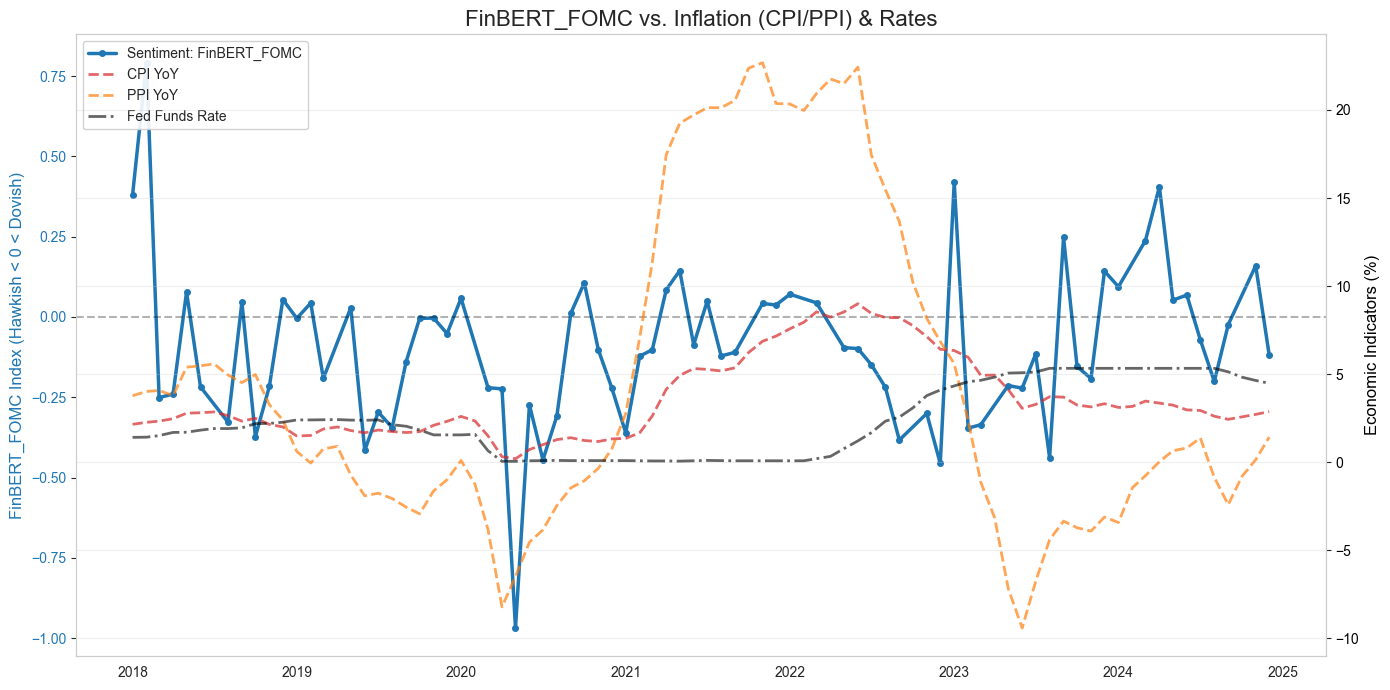

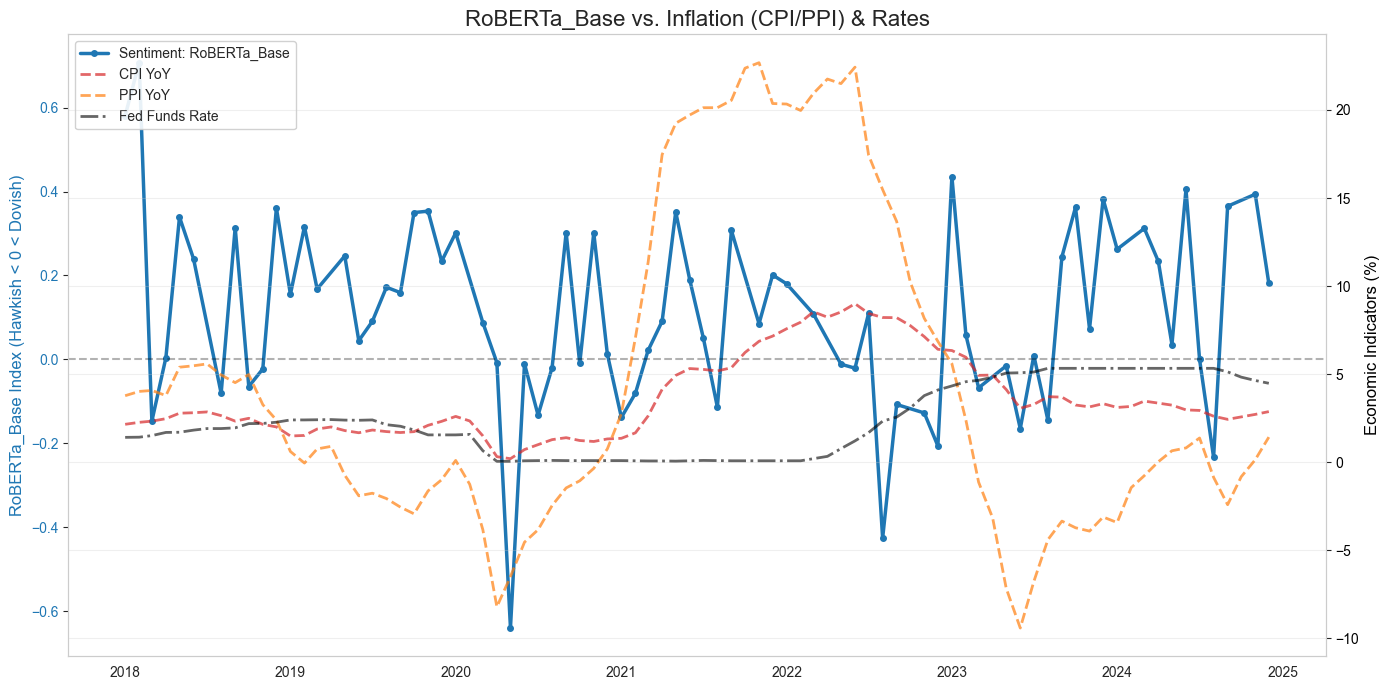

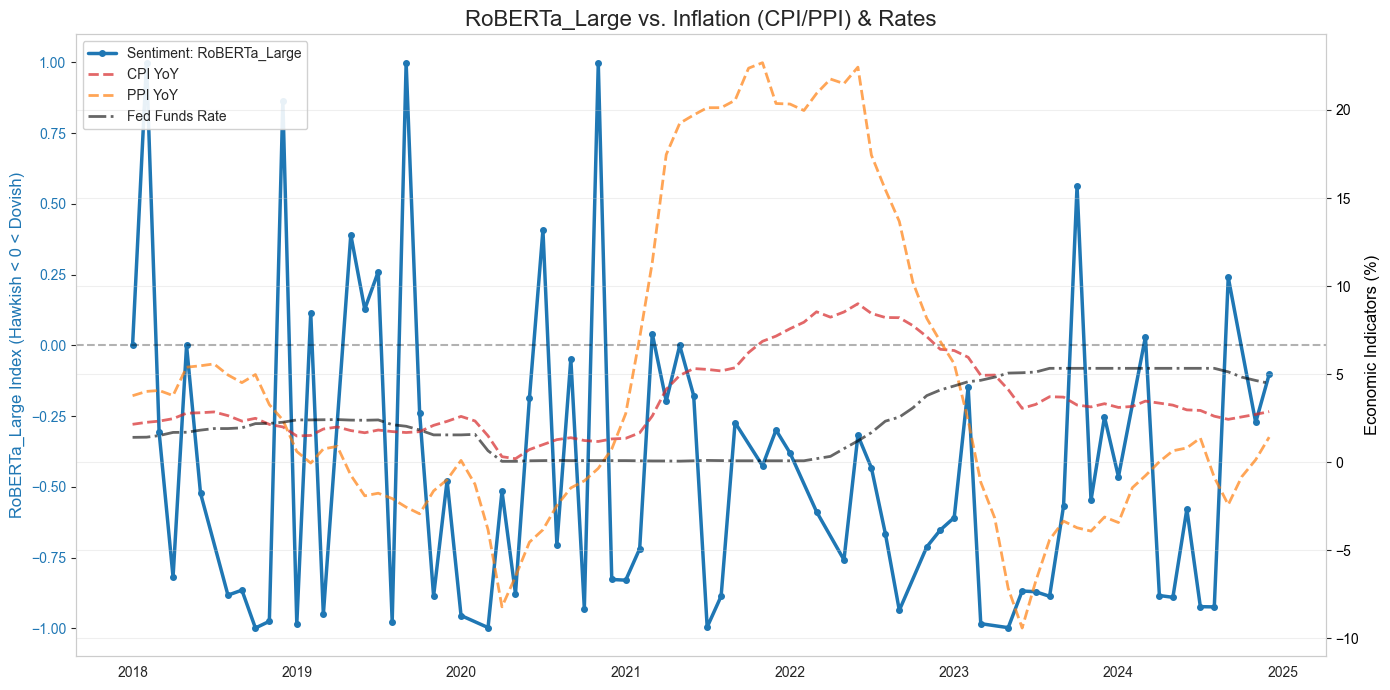

In [24]:
# Separate Dual-Axis Plots for Each Model
if 'df_merged' in locals() and not df_merged.empty and not df_econ.empty:
    models = df_merged.columns
    
    for model_name in models:
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Left Axis: Model Sentiment
        # Plot Sentiment
        ax1.plot(df_merged.index, df_merged[model_name], label=f'Sentiment: {model_name}', 
                 color='tab:blue', linewidth=2.5, marker='o', markersize=4)
        
        ax1.set_ylabel(f"{model_name} Index (Hawkish < 0 < Dovish)", fontsize=12, color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
        ax1.grid(False) # Turn off grid for ax1 to avoid clutter with ax2
        
        # Right Axis: Economic Indicators
        ax2 = ax1.twinx()
        ax2.plot(df_econ.index, df_econ['CPI_YoY'], label='CPI YoY', color='tab:red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.plot(df_econ.index, df_econ['PPI_YoY'], label='PPI YoY', color='tab:orange', linestyle='--', alpha=0.7, linewidth=2)
        ax2.plot(df_econ.index, df_econ['Fed_Funds_Rate'], label='Fed Funds Rate', color='black', linestyle='-.', alpha=0.6, linewidth=2)
        
        ax2.set_ylabel("Economic Indicators (%)", fontsize=12, color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(True, alpha=0.3)
        
        # Combined Legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, fancybox=True, framealpha=0.9)
        
        plt.title(f"{model_name} vs. Inflation (CPI/PPI) & Rates", fontsize=16)
        plt.tight_layout()
        plt.show()

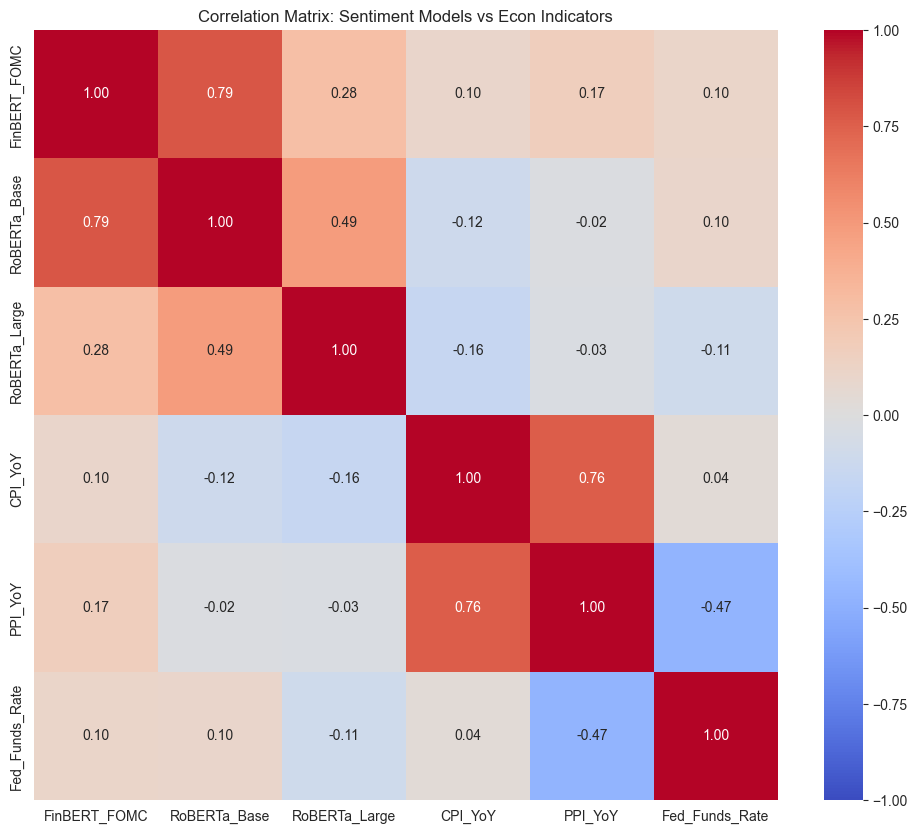

In [25]:
# Correlation Matrix including Econ Indicators
if 'df_merged' in locals() and not df_merged.empty and not df_econ.empty:
    # Merge Sentiment and Econ
    df_analysis = df_merged.join(df_econ[['CPI_YoY', 'PPI_YoY', 'Fed_Funds_Rate']], how='inner')
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_analysis.corr(), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt=".2f")
    plt.title("Correlation Matrix: Sentiment Models vs Econ Indicators")
    plt.show()